In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import os, os.path
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from tqdm import tqdm
import geopy
from geopy.geocoders import Nominatim

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls gdrive/MyDrive/'AC297r Capstone QB Group'/Data/NOAA

In [ ]:
# path joining version for other paths
DIR = 'gdrive/MyDrive/AC297r Capstone QB Group/Data/NOAA/ghcnd_hcn'

US_station_files = [name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]
US_station_IDs = [station[:-4] for station in US_station_files]

In [ ]:
"""
File: read_ghcn.py
Author: ned haughton
Description: Code for reading GHCN dly file data
"""


# Metadata specs #

metadata_col_specs = [
    (0,  12),
    (12, 21),
    (21, 31),
    (31, 38),
    (38, 41),
    (41, 72),
    (72, 76),
    (76, 80),
    (80, 86)
]

metadata_names = [
    "ID",
    "LATITUDE",
    "LONGITUDE",
    "ELEVATION",
    "STATE",
    "NAME",
    "GSN FLAG",
    "HCN/CRN FLAG",
    "WMO ID"]

metadata_dtype = {
    "ID": str,
    "STATE": str,
    "NAME": str,
    "GSN FLAG": str,
    "HCN/CRN FLAG": str,
    "WMO ID": str
    }


# Data specs #

data_header_names = [
    "ID",
    "YEAR",
    "MONTH",
    "ELEMENT"]

data_header_col_specs = [
    (0,  11),
    (11, 15),
    (15, 17),
    (17, 21)]

data_header_dtypes = {
    "ID": str,
    "YEAR": int,
    "MONTH": int,
    "ELEMENT": str}

data_col_names = [[
    "VALUE" + str(i + 1),
    "MFLAG" + str(i + 1),
    "QFLAG" + str(i + 1),
    "SFLAG" + str(i + 1)]
    for i in range(31)]
# Join sub-lists
data_col_names = sum(data_col_names, [])

data_replacement_col_names = [[
    ("VALUE", i + 1),
    ("MFLAG", i + 1),
    ("QFLAG", i + 1),
    ("SFLAG", i + 1)]
    for i in range(31)]
# Join sub-lists
data_replacement_col_names = sum(data_replacement_col_names, [])
data_replacement_col_names = pd.MultiIndex.from_tuples(
    data_replacement_col_names,
    names=['VAR_TYPE', 'DAY'])

data_col_specs = [[
    (21 + i * 8, 26 + i * 8),
    (26 + i * 8, 27 + i * 8),
    (27 + i * 8, 28 + i * 8),
    (28 + i * 8, 29 + i * 8)]
    for i in range(31)]
data_col_specs = sum(data_col_specs, [])

data_col_dtypes = [{
    "VALUE" + str(i + 1): int,
    "MFLAG" + str(i + 1): str,
    "QFLAG" + str(i + 1): str,
    "SFLAG" + str(i + 1): str}
    for i in range(31)]
data_header_dtypes.update({k: v for d in data_col_dtypes for k, v in d.items()})


# Reading functions #

def read_station_metadata(filename="gdrive/MyDrive/AC297r Capstone QB Group/Data/NOAA/ghcnd-stations.txt"):
    """Reads in station metadata

    :filename: ghcnd station metadata file.
    :returns: station metadata as a pandas Dataframe

    """
    df = pd.read_fwf(filename, metadata_col_specs, names=metadata_names,
                     index_col='ID', dtype=metadata_dtype)

    return df


def read_ghcn_data_file(filename="gdrive/MyDrive/AC297r Capstone QB Group/Data/NOAA/ghcnd_hcn/USW00094728.dly",
                        variables=None, include_flags=False,
                        dropna='all'):
    """Reads in all data from a GHCN .dly data file

    :param filename: path to file
    :param variables: list of variables to include in output dataframe
        e.g. ['TMAX', 'TMIN', 'PRCP']
    :param include_flags: Whether to include data quality flags in the final output
    :returns: Pandas dataframe
    """

    df = pd.read_fwf(
        filename,
        colspecs=data_header_col_specs + data_col_specs,
        names=data_header_names + data_col_names,
        index_col=data_header_names,
        dtype=data_header_dtypes
        )

    if variables is not None:
        df = df[df.index.get_level_values('ELEMENT').isin(variables)]

    df.columns = data_replacement_col_names

    if not include_flags:
        df = df.loc[:, ('VALUE', slice(None))]
        df.columns = df.columns.droplevel('VAR_TYPE')

    df = df.stack(level='DAY').unstack(level='ELEMENT')

    if dropna:
        df.replace(-9999.0, pd.np.nan, inplace=True)
        df.dropna(how=dropna, inplace=True)

    # replace the entire index with the date.
    # This loses the station ID index column!
    # This will usuall fail if dropna=False, since months with <31 days
    # still have day=31 columns
    df.index = pd.to_datetime(
        df.index.get_level_values('YEAR') * 10000 +
        df.index.get_level_values('MONTH') * 100 +
        df.index.get_level_values('DAY'),
        format='%Y%m%d')

    return df

stations = read_station_metadata().reset_index()

US_stations = stations[[station in US_station_IDs for station in stations['ID']]]
US_stations.head(5)

,ID,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN FLAG,HCN/CRN FLAG,WMO ID
92085,USC00011084,31.0583,-87.0550,25.9,AL,BREWTON 3 SSE,NaN,HCN,NaN
92146,USC00012813,30.5467,-87.8808,7.0,AL,FAIRHOPE 2 NE,NaN,HCN,NaN
92161,USC00013160,32.8347,-88.1342,38.1,AL,GAINESVILLE LOCK,NaN,HCN,NaN
92171,USC00013511,32.6922,-87.5761,75.9,AL,GREENSBORO,NaN,HCN,NaN
92191,USC00013816,31.8814,-86.2503,132.0,AL,HIGHLAND HOME,NaN,HCN,NaN


In [ ]:
# Create test set of all counties
state_county_fip = pd.read_csv('state_county_fip.csv')
test_set = pd.read_csv('County_450.csv')

state_county_fip['test'] = np.zeros(len(state_county_fip))
for i, fip in enumerate(state_county_fip['fips']):
    if fip in test_set['county'].values:
        state_county_fip['test'][i] = 1

fip_test_set = state_county_fip[state_county_fip['test'] > 0].reset_index(drop=True).copy()

# # get city for stations through reverse geocode
# county_list = []
# for station in tqdm(US_stations.iterrows()):
#     coordinates = str(station[1]['LATITUDE']) + ', ' + str(station[1]['LONGITUDE'])

#     location = locator.reverse(coordinates)
    
#     try:
#         county_list.append(location.raw['address']['county'])
#     except:
#         county_list.append('')
# 
# US_stations['County'] = county_list
# US_stations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# get coordinates for counties through geocode
locator = Nominatim(user_agent="NOAA-data-to-county")

fip_test_set['LAT'] = np.zeros(len(fip_test_set))
fip_test_set['LON'] = np.zeros(len(fip_test_set))

for i, name in tqdm(enumerate(fip_test_set['name'])):
    
    raw = locator.geocode(name + ', ' + fip_test_set['state'][i])

    try:
        fip_test_set['LAT'][i] = raw.latitude
    except:
        fip_test_set['LAT'][i] = -9999
    try:
        fip_test_set['LON'][i] = raw.longitude
    except:
        fip_test_set['LAT'][i] = -9999

fip_test_set.head(5)

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
210it [01:44,  1.98it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

,fips,name,state,test,LAT,LON
0,1007,Bibb County,AL,1.0,32.971079,-87.122709
1,1067,Henry County,AL,1.0,31.483804,-85.244738
2,1077,Lauderdale County,AL,1.0,34.904955,-87.674740
3,1095,Marshall County,AL,1.0,34.339605,-86.330180
4,1099,Monroe County,AL,1.0,31.559393,-87.378100
...,...,...,...,...,...,...
445,56017,Hot Springs County,WY,1.0,43.700875,-108.409568
446,56021,Laramie County,WY,1.0,41.273732,-104.726823
447,56031,Platte County,WY,1.0,42.092314,-104.987099
448,56037,Sweetwater County,WY,1.0,41.623947,-108.970231


In [ ]:
# find closest weather stations through norm minimizaion
county_points = np.stack((fip_test_set['LAT'],  fip_test_set['LON']), axis = 1)
weather_station_points = np.stack((US_stations['LATITUDE'],  US_stations['LONGITUDE']), axis = 1)

closest_station = []
for county in county_points:
    dist = []
    for station in weather_station_points:
        dist.append(np.linalg.norm(county - station))

    closest_station.append(US_stations['ID'].values[np.argmin(dist)])

fip_test_set['closest_station'] = closest_station


In [ ]:
fip_test_set.head(5)

,fips,name,state,test,LAT,LON,closest_station
0,1007,Bibb County,AL,1.0,32.971079,-87.122709,USC00013511
1,1067,Henry County,AL,1.0,31.483804,-85.244738,USC00018438
2,1077,Lauderdale County,AL,1.0,34.904955,-87.674740,USW00013896
3,1095,Marshall County,AL,1.0,34.339605,-86.330180,USC00017304
4,1099,Monroe County,AL,1.0,31.559393,-87.378100,USC00018178


In [ ]:

df_list = []
for station_ID in tqdm(fip_test_set['closest_station'].values):
    file_name = station_ID + '.dly'
    test_df = read_ghcn_data_file(os.path.join(DIR, file_name)).reset_index()

    test_df = test_df.loc[test_df['index'] >= '2012-01-01'].reset_index(drop=True)
    
    if len(test_df) == 0:
        df_list.append([])
    else:
        df_list.append(test_df)


100%|██████████| 450/450 [05:40<00:00,  1.32it/s]


In [ ]:


read_ghcn_data_file(os.path.join(DIR, fip_test_set['closest_station'][10] + '.dly')).reset_index()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:148: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


ELEMENT,index,DAPR,MDPR,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WT01,WT03,WT04,WT05,WT06,WT07,WT08,WT10,WT11,WT14
0,1893-03-01,NaN,NaN,0.0,0.0,0.0,300.0,-6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1893-03-12,NaN,NaN,0.0,0.0,0.0,256.0,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1893-03-13,NaN,NaN,0.0,0.0,0.0,239.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1893-03-14,NaN,NaN,0.0,0.0,0.0,250.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1893-03-15,NaN,NaN,0.0,0.0,0.0,239.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38577,2003-11-26,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38578,2003-11-27,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38579,2003-11-28,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38580,2003-11-29,NaN,NaN,0.0,0.0,0.0,233.0,67.0,211.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:

for i, df in tqdm(enumerate(df_list)):
    if len(df) == 0:
        df_list[i] = pd.DataFrame(columns = test_df.columns)
        df_list[i]['County'] = []
        df_list[i]['Station_ID'] = []
        df_list[i]['LATITUDE'] = []
        df_list[i]['LONGITUDE'] = []
        df_list[i]['STATE'] = []
        df_list[i]['FIP'] = []
    else:
        station_ID = fip_test_set['closest_station'].values[i]
        df_list[i] = df_list[i].assign(Station_ID = station_ID)
        df_list[i] = df_list[i].assign(County = fip_test_set[fip_test_set['closest_station'] == station_ID]['name'].iloc[0])
        df_list[i] = df_list[i].assign(STATE = fip_test_set[fip_test_set['closest_station'] == station_ID]['state'].iloc[0])
        df_list[i] = df_list[i].assign(LATITUDE = fip_test_set[fip_test_set['closest_station'] == station_ID]['LAT'].iloc[0])
        df_list[i] = df_list[i].assign(LONGITUDE = fip_test_set[fip_test_set['closest_station'] == station_ID]['LON'].iloc[0])
        df_list[i] = df_list[i].assign(FIP = fip_test_set[fip_test_set['closest_station'] == station_ID]['fips'].iloc[0])

df_list[0].head(5)

450it [00:02, 154.68it/s]


ELEMENT,index,DAPR,MDPR,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WT01,WT03,WT04,WT05,Station_ID,County,STATE,LATITUDE,LONGITUDE,FIP
0,2012-01-01,NaN,NaN,0.0,NaN,NaN,189.0,100.0,139.0,NaN,NaN,NaN,NaN,USC00013511,Bibb County,AL,32.971079,-87.122709,1007
1,2012-01-02,NaN,NaN,0.0,NaN,NaN,139.0,11.0,61.0,NaN,NaN,NaN,NaN,USC00013511,Bibb County,AL,32.971079,-87.122709,1007
2,2012-01-03,NaN,NaN,0.0,NaN,NaN,61.0,-33.0,6.0,NaN,NaN,NaN,NaN,USC00013511,Bibb County,AL,32.971079,-87.122709,1007
3,2012-01-04,NaN,NaN,0.0,NaN,NaN,128.0,-56.0,78.0,NaN,NaN,NaN,NaN,USC00013511,Bibb County,AL,32.971079,-87.122709,1007
4,2012-01-05,NaN,NaN,0.0,NaN,NaN,172.0,6.0,106.0,NaN,NaN,NaN,NaN,USC00013511,Bibb County,AL,32.971079,-87.122709,1007


In [ ]:

df_combined = pd.concat(df_list, ignore_index=True, join = 'inner')


In [ ]:
df_combined.to_csv('US_Weather_County_2012_2022.csv')

In [ ]:
df_combined['year-month-week'] = df_combined['index'].dt.year.astype(str) + '-' + df_combined['index'].dt.month.astype(str) + '-' + df_combined['index'].dt.week.astype(str)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


In [ ]:
df_combined_weekly = df_combined.groupby(['FIP', 'STATE', 'County', 'year-month-week'], as_index=False).agg({
    'PRCP' : ['sum', 'mean'], 'SNWD' : ['sum', 'mean'], 'TMAX' : ['mean', 'min', 'max'], 'TMIN' : ['mean', 'min', 'max']})



In [ ]:
len(df_combined_weekly['FIP'].unique())

332

In [ ]:
df_combined_weekly.to_csv('US_Weather_County_2012_2022_weekly.csv')

In [ ]:
!cp US_Weather_County_2012_2022_weekly.csv gdrive/MyDrive/'AC297r Capstone QB Group'/Data/NOAA/US_Weather_County_2012_2022_weekly.csv
!cp US_Weather_County_2012_2022.csv gdrive/MyDrive/'AC297r Capstone QB Group'/Data/NOAA/US_Weather_County_2012_2022.csv

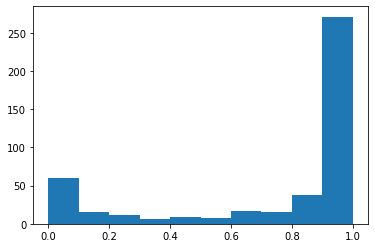

In [ ]:
# plt.hist()
# plt.show()
lengths = np.array([len(x) for x in df_list])
plt.hist(lengths/3733)
plt.show()